In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


I was ranked 363 by running below code and submit the results

I hope my notebook helps you

The notebook i branched from had an excellent treatment of the hyper params and combining random forest and boosting etc. 

The only changes so far are in the dropping of irrelevant columns

# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor




import lightgbm as lgb

In [32]:
#!pip install numba==0.58.1

#!pip install --upgrade ydata-profiling


In [4]:
train_df=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [5]:
test_df=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [7]:
#from ydata_profiling import ProfileReport

#profile = ProfileReport(train_df, title='Pandas Profiling Report')
#profile = ProfileReport(train)
#profile.to_notebook_iframe() # use this line to show the output


AttributeError: module 'numba' has no attribute 'generated_jit'

# doing scatterplot for numeric columns for removing outliers

In [6]:
# At first we will do scatterplot for numeric columns and remove outliers
def plot_data_scatterplot_for_train_df(x):
    
   plt.figure(figsize=(5, 3))
   sns.scatterplot(x=x, y='SalePrice', data=train_df)
   plt.show()

In [7]:
train_df.columns[train_df.dtypes != 'object']

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

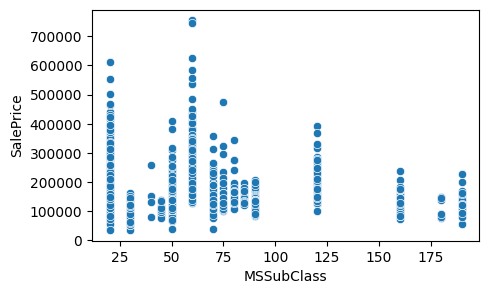

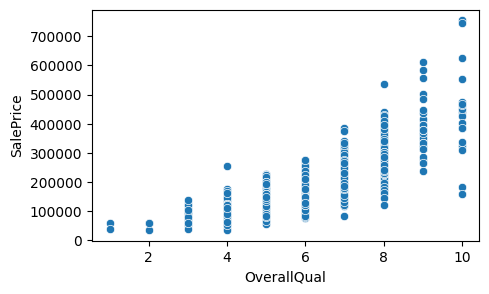

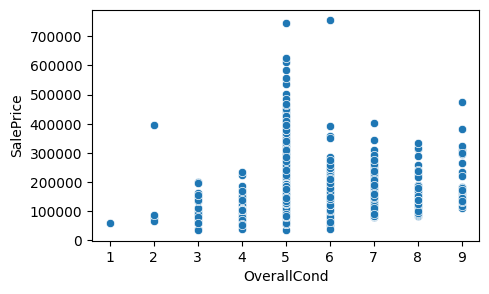

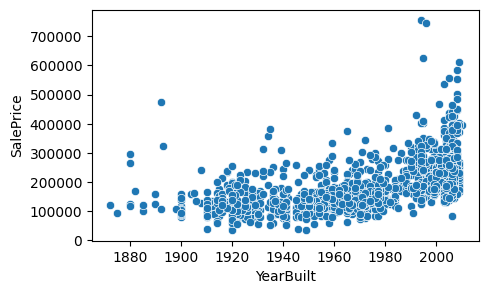

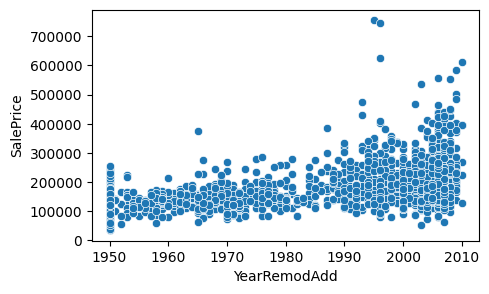

In [8]:
plot_data_scatterplot_for_train_df('MSSubClass')

plot_data_scatterplot_for_train_df('OverallQual')

plot_data_scatterplot_for_train_df('OverallCond')
plot_data_scatterplot_for_train_df('YearBuilt')
plot_data_scatterplot_for_train_df('YearRemodAdd')




in the above columns don't have outliers

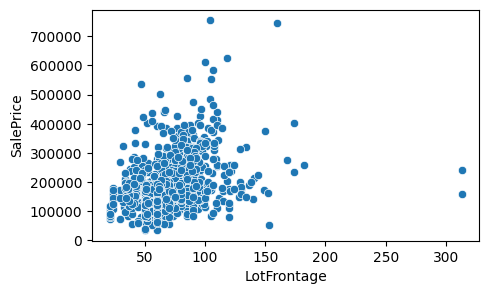

In [9]:
plot_data_scatterplot_for_train_df('LotFrontage')

In [10]:
train_df.query('LotFrontage> 200')



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


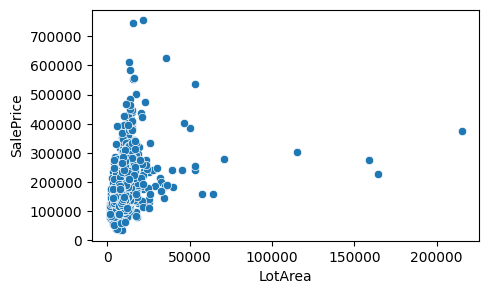

In [11]:
plot_data_scatterplot_for_train_df('LotArea')

In [12]:
train_df.query('LotArea >100000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000


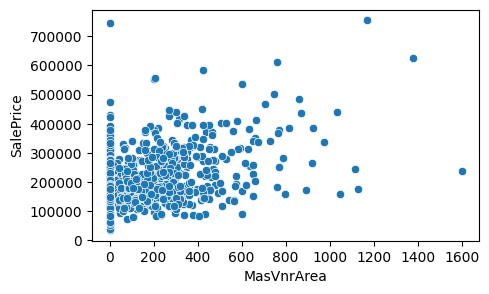

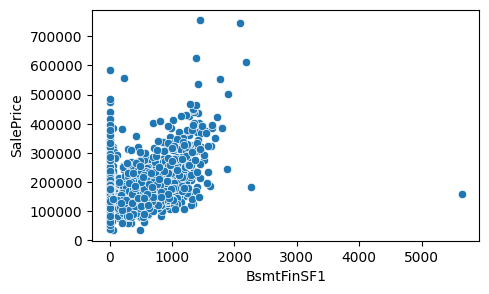

In [13]:
plot_data_scatterplot_for_train_df('MasVnrArea')
plot_data_scatterplot_for_train_df('BsmtFinSF1')

In [14]:
train_df.query('BsmtFinSF1 >4000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [15]:
train_df.query('MasVnrArea >1200')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000


In [16]:
values = [934,1298,298,1170,250,314,336,707,1299,323,305,692,206,1424,198,347,1231,1329,584,496,54,333,441,497,1183,692,524]
train_df = train_df[train_df.Id.isin(values) == False]

# Handling null values in data set

In [17]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)

,0
PoolQC,1431
MiscFeature,1385
Alley,1345
Fence,1159
MasVnrType,858
FireplaceQu,685
LotFrontage,252
GarageYrBlt,80
GarageCond,80
GarageType,80


The main difference so far between the code i branched and mine is that i am dropping a lot of unnecessary columns. 
Columns with High Missing Values:
PoolQC, MiscFeature, Alley, Fence, FireplaceQu: These columns have a high percentage of missing values, making them less reliable for prediction.

Columns with Low Variance:
    Utilities: This column has very little variance (almost all entries have the same value), so it doesn’t contribute much to the model.
Redundant Columns:
Id: This is just an identifier and doesn’t provide any useful information for predicting house prices.
Highly Correlated Columns:
GarageYrBlt: This is highly correlated with YearBuilt. Including both can lead to multicollinearity issues.
Columns with Irrelevant Information:
    Street: The type of street (paved or gravel) might not have a significant impact on house prices.


In [18]:
# Drop columns
columns_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                   'Utilities',  'GarageYrBlt', 'Street']

train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

print(train_df.head())



   Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape LandContour  \
0   1          60       RL         65.0     8450      Reg         Lvl   
1   2          20       RL         80.0     9600      Reg         Lvl   
2   3          60       RL         68.0    11250      IR1         Lvl   
3   4          70       RL         60.0     9550      IR1         Lvl   
4   5          60       RL         84.0    14260      IR1         Lvl   

  LotConfig LandSlope Neighborhood  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0    Inside       Gtl      CollgCr  ...             0         0           0   
1       FR2       Gtl      Veenker  ...             0         0           0   
2    Inside       Gtl      CollgCr  ...             0         0           0   
3    Corner       Gtl      Crawfor  ...           272         0           0   
4       FR2       Gtl      NoRidge  ...             0         0           0   

  PoolArea  MiscVal  MoSold  YrSold  SaleType SaleCondition SalePrice  
0        0    

In [19]:

train_df['MasVnrType'].fillna('No', inplace=True)
test_df['MasVnrType'].fillna('No', inplace=True)
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

train_df['LotFrontage'].fillna(0, inplace=True)
test_df['LotFrontage'].fillna(0, inplace=True)
train_df['GarageCond'].fillna('No', inplace=True)
test_df['GarageCond'].fillna('No', inplace=True)
train_df['GarageType'].fillna('No', inplace=True)
test_df['GarageType'].fillna('No', inplace=True)
train_df['GarageFinish'].fillna('No', inplace=True)
test_df['GarageFinish'].fillna('No', inplace=True)
train_df['GarageQual'].fillna('No', inplace=True)
test_df['GarageQual'].fillna('No', inplace=True)
train_df['BsmtFinType2'].fillna('No', inplace=True)
test_df['BsmtFinType2'].fillna('No', inplace=True)
train_df['BsmtExposure'].fillna('No', inplace=True)
test_df['BsmtExposure'].fillna('No', inplace=True)
train_df['BsmtQual'].fillna('No', inplace=True)
test_df['BsmtQual'].fillna('No', inplace=True)
train_df['BsmtCond'].fillna('No', inplace=True)
test_df['BsmtCond'].fillna('No', inplace=True)
train_df['BsmtFinType1'].fillna('No', inplace=True)
test_df['BsmtFinType1'].fillna('No', inplace=True)
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)
train_df['Electrical'].fillna('No', inplace=True)
test_df['Electrical'].fillna('No', inplace=True)

/tmp/ipykernel_30/3788813353.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrType'].fillna('No', inplace=True)
/tmp/ipykernel_30/3788813353.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

# Feature Engineering 

<Axes: >

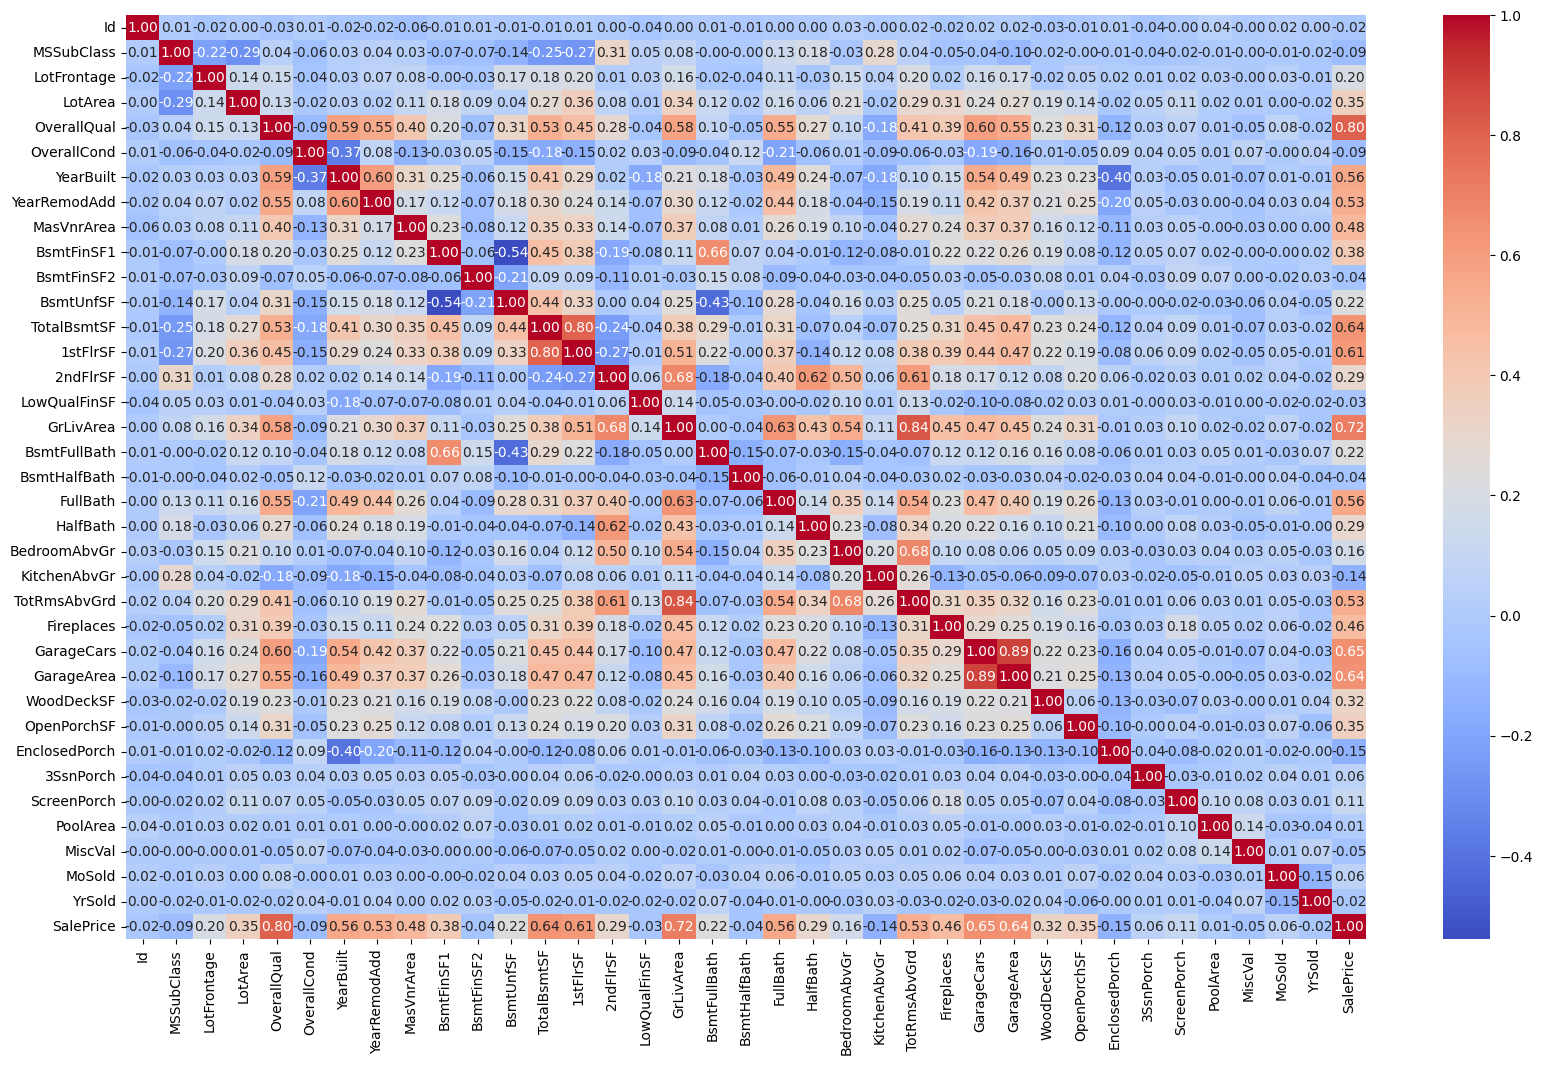

In [20]:
correlation_matrix = train_df.corr(numeric_only=True)


plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [18]:
print(type(train_df))

<class 'pandas.core.frame.DataFrame'>


In [23]:
train_df['totalbaths'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath']) 
test_df['totalbaths'] = test_df['BsmtFullBath'] + test_df['FullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath']) 
train_df['totalporchsf'] = train_df['OpenPorchSF'] + train_df['3SsnPorch'] + train_df['EnclosedPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['totalporchsf'] = test_df['OpenPorchSF'] + test_df['3SsnPorch'] + test_df['EnclosedPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']
train_df['TotalRooms'] = train_df['TotRmsAbvGrd'] + train_df['FullBath'] + train_df['HalfBath']
test_df['TotalRooms'] = train_df['TotRmsAbvGrd'] + train_df['FullBath'] + train_df['HalfBath']


In [24]:
train_df['houseage'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['houseage'] = test_df['YrSold'] - test_df['YearBuilt']
train_df['houseremodelage'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['houseremodelage'] = test_df['YrSold'] - test_df['YearRemodAdd']
train_df['totalsf'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
test_df['totalsf'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']
train_df['totalarea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['totalarea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']


In [25]:
train_df = train_df.drop(columns=[  'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=[  'GarageCond', 'BsmtFinType2'])

In [26]:
train_df = train_df.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath','BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath','HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

In [27]:
train_df = train_df.drop(columns=['GarageArea'])
test_df = test_df.drop(columns=['GarageArea'])

# We will log transform the 'SalePrice' column

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

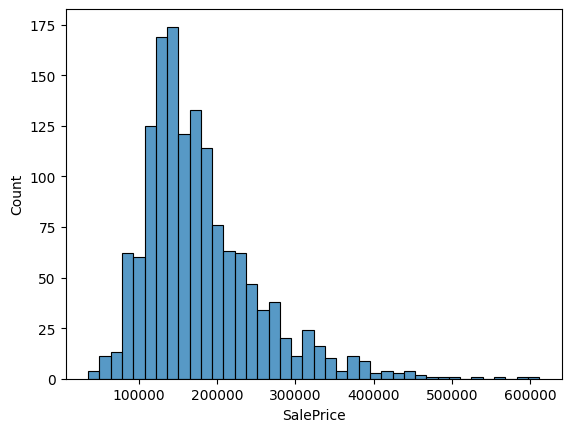

In [28]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [29]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

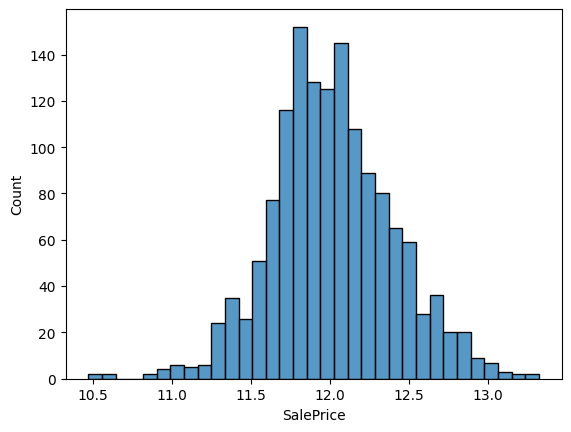

In [30]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

# Encoding of columns

In [31]:
ode_cols = ['LotShape', 'LandContour','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', 
    
           'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']
ohe_cols = [ 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [32]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

# Creating Pipelines

In [33]:

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Building Column transformer

In [34]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

# Splitting data

In [35]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [36]:
X_preprocessed = col_trans.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

# Model Training

In [ ]:
RFR = RandomForestRegressor(random_state=13)
param_grid_RFR = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rfr_cv.fit(X_train, y_train)
rfr_cv.best_params_

KeyboardInterrupt: 

In [ ]:
np.sqrt(-1 * rfr_cv.best_score_)

In [ ]:
rfr_final = RandomForestRegressor(max_depth= 15, min_samples_split=3, n_estimators= 500,random_state=13)
rfr_final.fit(X_train, y_train)

In [ ]:
XGB = XGBRegressor(random_state=13)
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],}
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_cv.fit(X_train, y_train)
xgb_cv.best_params_

In [ ]:
np.sqrt(-1 * xgb_cv.best_score_)

In [ ]:
xgb_final = XGBRegressor(random_state=13,colsample_bytree= 0.8,gamma= 0,learning_rate= 0.05,max_depth= 3,min_child_weight= 3,n_estimators=300,subsample= 0.8)
xgb_final.fit(X_train, y_train)

In [ ]:
ridge = Ridge()

param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_cv.fit(X_train, y_train)
print(np.sqrt(-1 * ridge_cv.best_score_))
ridge_cv.best_params_

In [ ]:
np.sqrt(-1 * ridge_cv.best_score_)

In [ ]:
ridge_final=Ridge(alpha=10, solver= 'sag')
ridge_final.fit(X_train, y_train)

In [ ]:
lgbm_regressor = lgb.LGBMRegressor()
param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'verbosity': [-1]
}
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_cv.fit(X_train, y_train)
lgbm_cv.best_params_

In [ ]:
np.sqrt(-1 * lgbm_cv.best_score_)

In [ ]:
lgbm_final = lgb.LGBMRegressor(boosting_type= 'gbdt',learning_rate= 0.05,n_estimators= 200,num_leaves=20)
lgbm_final.fit(X_train, y_train)

In [ ]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
cat_cv.fit(X_train, y_train)
cat_cv.best_params_

In [ ]:
np.sqrt(-1 * cat_cv.best_score_)

In [ ]:
catboost_final=CatBoostRegressor(loss_function='RMSE', verbose=False,depth=5,iterations= 500, learning_rate= 0.05)
catboost_final.fit(X_train, y_train)

# Voting and Stacking

In [ ]:
vr = VotingRegressor([('rfr', rfr_final),
                      ('xgb', xgb_final),
                      ('ridge', ridge_final),
                      ('lgbm',lgbm_final),
                      ('cat',catboost_final)],
                    weights=[1,1,1,1,1])
vr.fit(X_train, y_train)

In [ ]:
y_pred_vr = vr.predict(X_test)
mean_squared_error(y_test, y_pred_vr, squared=False)

In [ ]:
estimators = [
    
    ('xgb', xgb_final),
    ('cat', catboost_final),
    ('lgb', lgbm_final),
    ('rfr', rfr_final),
    ('ridge', ridge_final)

]
stackreg = StackingRegressor(
            estimators = estimators,
    final_estimator= vr
   
)
stackreg.fit(X_train, y_train)

In [ ]:
y_pred_stack = stackreg.predict(X_test)
mean_squared_error(y_test, y_pred_stack, squared=False)

# Creating submission.csv

In [ ]:
df_test_preprocess = col_trans.transform(test_df)
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)